In [1]:
import keras
from keras import layers
import numpy as np
from load_data import load_data
import tensorflow as tf
from tensorflow.nn import depth_to_space
import matplotlib.pyplot as plt

c:\Users\nedst\Desktop\synoptic-project-NedStickler\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
residual_blocks = 5
downsample_factor = 4

In [3]:
package_path = r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\.venv\Lib\site-packages\tensorflow_datasets"
dataset, _ = load_data(package_path)
dataset = dataset[:32, :, :, :]
lr_dataset = np.array([image[::downsample_factor, ::downsample_factor, :] for image in dataset])

In [7]:
@keras.saving.register_keras_serializable()
class PixelShuffle(keras.Layer):
    def call(self, x):
        return depth_to_space(x, 2)
    
    def get_config(self):
        return {}
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def d_residual_block(x, n_filters, n_strides):
    x = layers.Conv2D(n_filters, kernel_size=3, strides=n_strides, padding="same")(x)
    # x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def d_downsample_pair(x, n_filters):
    x = d_residual_block(x, n_filters, 1)
    x = d_residual_block(x, n_filters, 2)
    return x

def g_residual_block(x_in):
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x_in)
    # x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Add()([x_in, x])
    return x

def discriminator():
    # HR/SR input
    inputs = layers.Input((None, None, 3))
    x = layers.Rescaling(scale=1/127.5, offset=-1)(inputs)
    
    # First convolution blocks
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Residual downsampling blocks
    x = d_residual_block(x, 64, 2)
    x = d_downsample_pair(x, 128)
    x = d_downsample_pair(x, 256)
    x = d_downsample_pair(x, 512)

    # Flatten and classify
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, x)


def generator(residual_blocks):
    # LR input
    inputs = layers.Input((None, None, 3))
    x_in = layers.Rescaling(scale=1/255)(inputs)

    # First convolution
    x_in = layers.Conv2D(64, kernel_size=3, padding="same")(x_in)
    x_in = x = layers.PReLU(shared_axes=[1, 2])(x_in)

    # Residual block set
    for _ in range(residual_blocks):
        x = g_residual_block(x)
    
    # Residual block without activation functions
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Add()([x_in, x])

    # Upscaling blocks
    x = layers.Conv2D(256, kernel_size=3, padding="same")(x)
    x = PixelShuffle()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    
    x = layers.Conv2D(256, kernel_size=3, padding="same")(x)
    x = PixelShuffle()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)

    # Final convolve
    x = layers.Conv2D(3, kernel_size=3, padding="same")(x)
    x = layers.Rescaling(scale=127.5, offset=127.5)(x)

    return keras.Model(inputs, x)

In [6]:
@keras.saving.register_keras_serializable()
class SRGAN(keras.Model):
    def __init__(self, discriminator, generator, vgg):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg

    def compile(self, d_optimiser, g_optimiser, bce_loss, mse_loss):
        super().compile()
        self.d_optimiser = d_optimiser
        self.g_optimiser = g_optimiser
        self.bce_loss = bce_loss
        self.mse_loss = mse_loss

    def get_config(self):
        return {
            "generator": self.generator,
            "discriminator": self.discriminator,
            "vgg": self.vgg
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def train_step(self, data):
        lr_images, hr_images = data
        batch_size = lr_images.shape[0]

        # Train the discriminator
        generated_images = self.generator(lr_images)
        combined_images = keras.ops.concatenate([generated_images, hr_images])
        d_labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.bce_loss(d_labels, predictions)
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimiser.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        # Train the generator
        misleading_labels = np.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(lr_images)
            predictions = self.discriminator(generated_images)
            
            g_loss = 0.001 * self.bce_loss(misleading_labels, predictions)

            sr_vgg = tf.keras.applications.vgg19.preprocess_input(generated_images)
            sr_vgg = self.vgg(sr_vgg) / 12.75

            hr_vgg = tf.keras.applications.vgg19.preprocess_input(hr_images)
            hr_vgg = self.vgg(hr_vgg) / 12.75

            perceptual_loss = self.mse_loss(hr_vgg, sr_vgg)
            g_total_loss = g_loss + perceptual_loss
        
        gradients = tape.gradient(g_total_loss, self.generator.trainable_weights)
        self.g_optimiser.apply_gradients(zip(gradients, self.generator.trainable_weights))

        losses = {
            "d_loss": d_loss,
            "g_total_loss": g_total_loss,
            "g_loss": g_loss,
            "pereceptual_loss": perceptual_loss
        }

        return losses

In [ ]:
vgg = keras.applications.VGG19(input_shape=(None, None, 3), weights="imagenet", include_top=False)
vgg = keras.Model(vgg.input, vgg.layers[20].output)

srgan = SRGAN(discriminator=discriminator(), generator=generator(residual_blocks), vgg=vgg)
srgan.compile(d_optimiser=keras.optimizers.Adam(learning_rate=0.0003), g_optimiser=keras.optimizers.Adam(learning_rate=0.0003), bce_loss=keras.losses.BinaryCrossentropy(), mse_loss=keras.losses.MeanSquaredError())

srgan.fit(lr_dataset, dataset, epochs=1, steps_per_epoch=1)

In [ ]:
srgan.generator.save(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\trained_models\srgan_s32e1b1.keras")

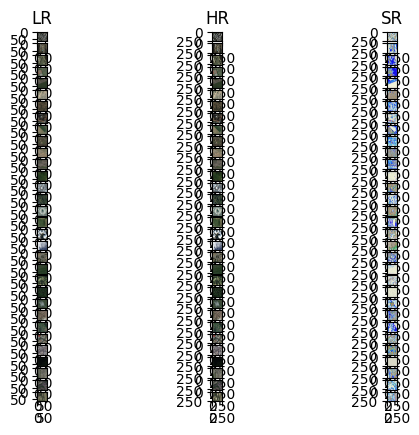

In [9]:
from utils import visualise_generator

loaded_generator = keras.saving.load_model(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\generators\srgan_s2048e35b32.keras")
visualise_generator(loaded_generator, lr_dataset, dataset)